In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ad20b092-0723-7872-0e22-0e53b09363a2)


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"  # NOTE: This is different from the Medium post!
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [5]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 94% 113M/121M [00:04<00:00, 40.2MB/s] 
100% 121M/121M [00:04<00:00, 29.2MB/s]


In [ ]:
!unzip \*.zip

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    'images/images/train',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = train_datagen.flow_from_directory(
    'images/images/validation',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)
filenames = test_generator.filenames

Found 7066 images belonging to 7 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(32, (2,2), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(7, activation='sigmoid'))

model.summary()

model.compile( optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 32)        4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9248)              0

In [10]:
class customCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy')>0.98:
      print("0.98 or 98% accuracy reached!")
      self.model.stop_training = True

In [11]:
history = model.fit_generator(generator = train_generator, epochs = 20, validation_data = test_generator, validation_steps = 20, callbacks=[customCallback()])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
451/451 [==============================] - 56s 50ms/step - loss: 1.8901 - accuracy: 0.2796 - val_loss: 1.4942 - val_accuracy: 0.4281
Epoch 2/20
451/451 [==============================] - 22s 49ms/step - loss: 1.4103 - accuracy: 0.4595 - val_loss: 1.3752 - val_accuracy: 0.4758
Epoch 3/20
451/451 [==============================] - 22s 48ms/step - loss: 1.1595 - accuracy: 0.5653 - val_loss: 1.2700 - val_accuracy: 0.5211
Epoch 4/20
451/451 [==============================] - 22s 48ms/step - loss: 0.8149 - accuracy: 0.7045 - val_loss: 1.3951 - val_accuracy: 0.5242
Epoch 5/20
451/451 [==============================] - 22s 49ms/step - loss: 0.4485 - accuracy: 0.8411 - val_loss: 1.7939 - val_accuracy: 0.5422
Epoch 6/20
451/451 [==============================] - 22s 48ms/step - loss: 0.2091 - accuracy: 0.9338 - val_loss: 2.6668 - val_accuracy: 0.4914
Epoch 7/20
451/451 [==============================] - 22s 48ms/step - loss: 0.1190 - accuracy: 0.9635 - val_loss: 2.6210 - val_accuracy:

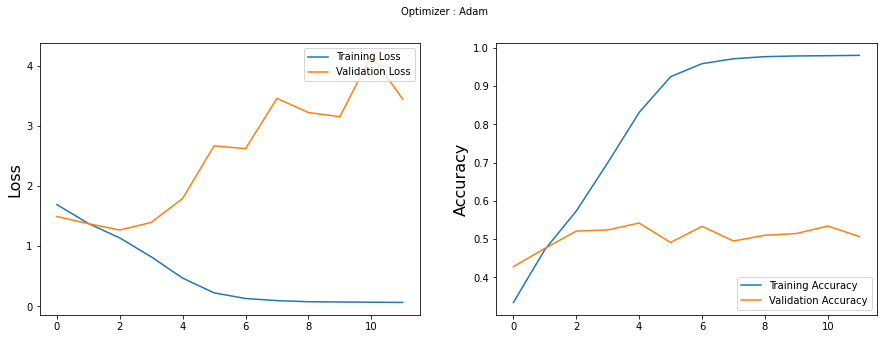

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()